# Máquinas de Soporte Vectorial con Validación Cruzada

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as ss
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [11]:
data = pd.read_csv('../Datasets/bank_deposit.csv')
data.head(5)

,idcliente,duration,previous,housing,campaign,loan,default,target,muestra
0,1,261,0,1,1,0,0,0,1
1,2,50,0,1,1,0,0,0,1
2,3,1492,0,1,1,0,0,0,1
3,4,104,0,1,1,0,0,0,1
4,5,13,0,1,1,0,0,0,1


In [12]:
data.dtypes

idcliente    int64
duration     int64
previous     int64
housing      int64
campaign     int64
loan         int64
default      int64
target       int64
muestra      int64
dtype: object

In [13]:
data['housing'] = data['housing'].astype(object)
data['loan'] = data['loan'].astype(object)
data['default'] = data['default'].astype(object)

El area de riesgo filtra los usuarios con ['default'] debido a que no pagan -> El problema de la cartera pesada/morosa

In [14]:
data.dtypes

idcliente     int64
duration      int64
previous      int64
housing      object
campaign      int64
loan         object
default      object
target        int64
muestra       int64
dtype: object

In [15]:
data['c_housing'] = LabelEncoder().fit_transform(data.housing.values)
data['c_loan'] = LabelEncoder().fit_transform(data.loan.values)
data['c_default'] = LabelEncoder().fit_transform(data.default.values)

In [16]:
data.head(5)

,idcliente,duration,previous,housing,campaign,loan,default,target,muestra,c_housing,c_loan,c_default
0,1,261,0,1,1,0,0,0,1,1,0,0
1,2,50,0,1,1,0,0,0,1,1,0,0
2,3,1492,0,1,1,0,0,0,1,1,0,0
3,4,104,0,1,1,0,0,0,1,1,0,0
4,5,13,0,1,1,0,0,0,1,1,0,0


Prueba de normalidad
* Ho: la variable se aproxima a una distribución normal
* Ha: la variable no se aproxima a una distribución normal

In [61]:
variables = ['duration', 'previous', 'campaign']
alpha = 0.05
for var in variables:
    stat, p_value = ss.shapiro(data[var])
    
    print(f'Prueba de normalidad para la variable {var}:')
    print(f'Estadístico de prueba: {stat:.2f}')
    print(f'P-valor: {p_value:.2f}')
    
    if p_value < alpha:
        print('La hipótesis nula (Ho) se rechaza.')
        print('La variable no se aproxima a una distribución normal.')
    else:
        print('La hipótesis nula (Ho) no se rechaza.')
        print('La variable se aproxima a una distribución normal.')
    print()

Prueba de normalidad para la variable duration:
Estadístico de prueba: 0.81
P-valor: 0.00
La hipótesis nula (Ho) se rechaza.
La variable no se aproxima a una distribución normal.

Prueba de normalidad para la variable previous:
Estadístico de prueba: 0.41
P-valor: 0.00
La hipótesis nula (Ho) se rechaza.
La variable no se aproxima a una distribución normal.

Prueba de normalidad para la variable campaign:
Estadístico de prueba: 0.56
P-valor: 0.00
La hipótesis nula (Ho) se rechaza.
La variable no se aproxima a una distribución normal.



c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Prueba de Correlación
* Ho: no existe correlación entre las variables
* Ha: existe correlación entre las variables

<Axes: >

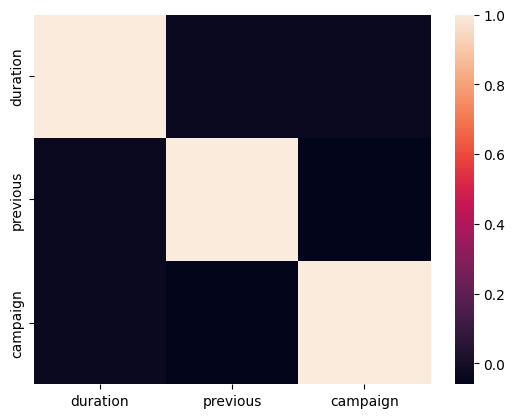

In [62]:
sns.heatmap(data.loc[:,['duration','previous','campaign']].corr())

In [64]:
data.loc[:,['duration','previous','campaign']].corr(method = "spearman")

,duration,previous,campaign
duration,1.000000,0.007392,-0.045111
previous,0.007392,1.000000,-0.133380
campaign,-0.045111,-0.133380,1.000000


In [63]:
variables = ['duration', 'previous', 'campaign']
alpha = 0.05
method = "spearmanr"
for i in range(len(variables)):
    for j in range(i+1, len(variables)):
        var1 = variables[i]
        var2 = variables[j]
        # para data no distribuida normalmente
        if method == "spearmanr": 
            correlation, p_value = ss.spearmanr(data[var1], data[var2])
            
        # para data no distribuida normalmente - preferido sobre spearman
        elif method == "kendall":
            correlation, p_value = ss.kendalltau(data[var1], data[var2])
            
        # para data distribuida normalmente
        elif method == "pearsonr":
            correlation, p_value = ss.pearsonr(data[var1], data[var2])

        
        print(f'Correlación entre {var1} y {var2}:')
        print(f'Coeficiente de correlación de {method}: {correlation:.2f}')
        print(f'P-valor: {p_value:.2f}')
        
        if p_value < alpha:
            print('La hipótesis nula (Ho) se rechaza.')
            print('Existe correlación entre las variables.')
        else:
            print('La hipótesis nula (Ho) no se rechaza.')
            print('No existe correlación entre las variables.')
        print()

Correlación entre duration y previous:
Coeficiente de correlación de spearmanr: 0.01
P-valor: 0.45
La hipótesis nula (Ho) no se rechaza.
No existe correlación entre las variables.

Correlación entre duration y campaign:
Coeficiente de correlación de spearmanr: -0.05
P-valor: 0.00
La hipótesis nula (Ho) se rechaza.
Existe correlación entre las variables.

Correlación entre previous y campaign:
Coeficiente de correlación de spearmanr: -0.13
P-valor: 0.00
La hipótesis nula (Ho) se rechaza.
Existe correlación entre las variables.



In [29]:
data.target.value_counts()

target
0    5289
1    5289
Name: count, dtype: int64

In [30]:
100*data['target'].value_counts(normalize=True)

target
0    50.0
1    50.0
Name: proportion, dtype: float64

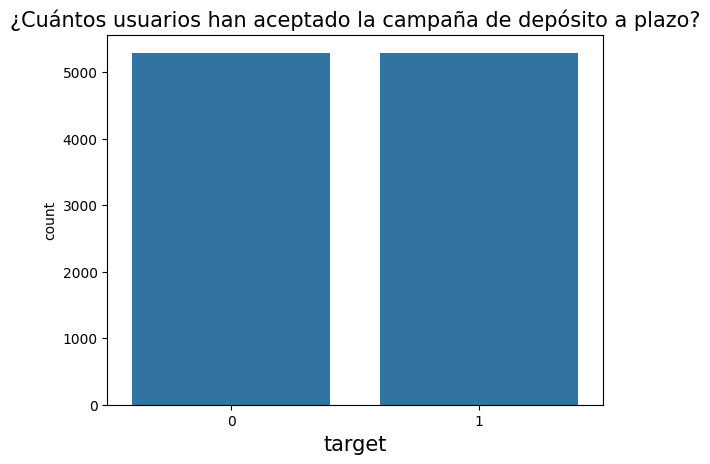

In [31]:
sns.countplot(data = data, x = 'target')
plt.xlabel('target', fontsize = 15)
plt.title('¿Cuántos usuarios han aceptado la campaña de depósito a plazo?', fontsize = 15)
plt.show()

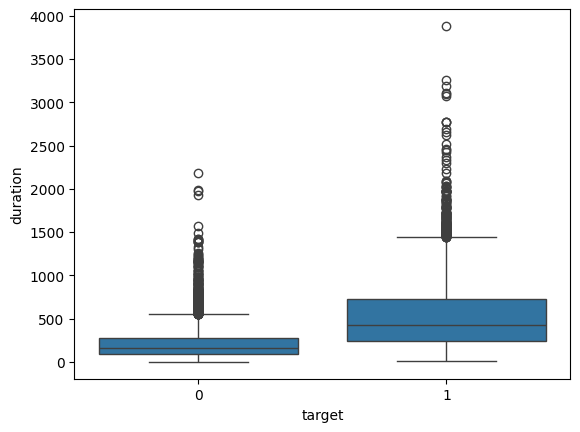

In [32]:
sns.boxplot(x='target',y='duration',data=data)

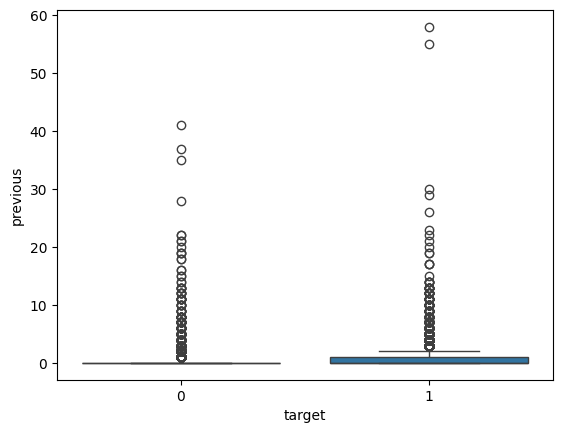

In [33]:
sns.boxplot(x='target',y='previous',data=data)

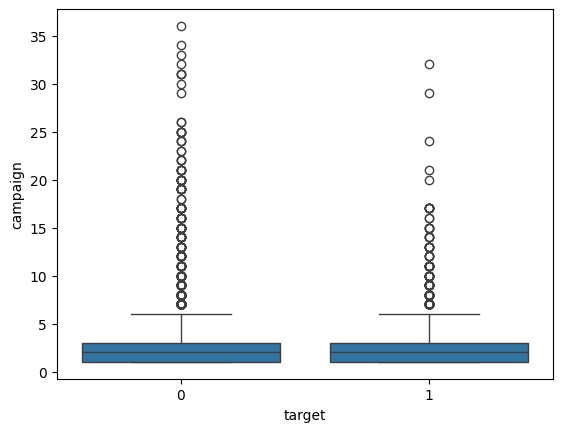

In [34]:
sns.boxplot(x='target',y='campaign',data=data)

housing     0     1
target             
0        2176  3113
1        3354  1935


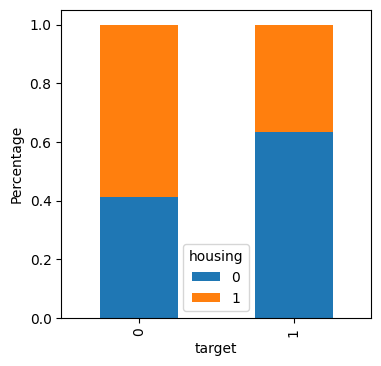

In [35]:
print(pd.crosstab(data["target"],data["housing"]))
t = pd.crosstab(data["target"],data["housing"])
t.div(t.sum(1).astype(float),axis=0).plot(kind="bar",stacked=True,figsize=(4,4))
plt.xlabel("target")
plt.ylabel("Percentage")
plt.show()

loan       0    1
target           
0       4359  930
1       4805  484


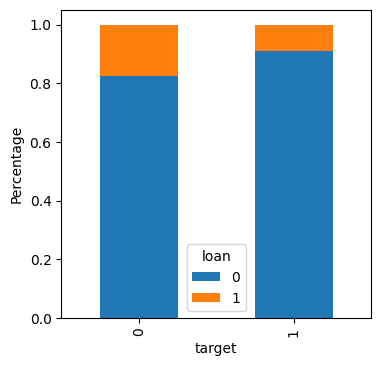

In [36]:
print(pd.crosstab(data["target"],data["loan"]))
t = pd.crosstab(data["target"],data["loan"])
t.div(t.sum(1).astype(float),axis=0).plot(kind="bar",stacked=True,figsize=(4,4))
plt.xlabel("target")
plt.ylabel("Percentage")
plt.show()

default     0   1
target           
0        5202  87
1        5237  52


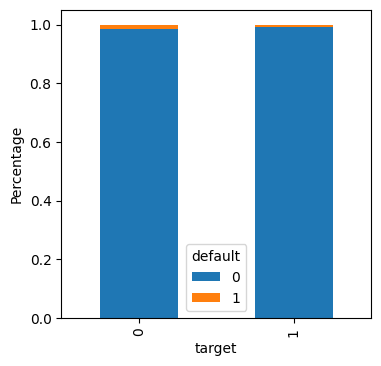

In [37]:
print(pd.crosstab(data["target"],data["default"]))
t = pd.crosstab(data["target"],data["default"])
t.div(t.sum(1).astype(float),axis=0).plot(kind="bar",stacked=True,figsize=(4,4))
plt.xlabel("target")
plt.ylabel("Percentage")
plt.show()

Prueba Chi-Cuadrado
* Ho: no existe dependencia entre las variables
* Ha: existe dependencia entre las variables

In [38]:
variables = ['target', 'housing', 'loan', 'default']
alpha = 0.05
for i in range(len(variables)):
    for j in range(i+1, len(variables)):
        var1 = variables[i]
        var2 = variables[j]
        
        contingency_table = pd.crosstab(data[var1], data[var2])
        chi2, p_value, dof, expected = ss.chi2_contingency(contingency_table)
        
        print(f'Prueba Chi-Cuadrado entre {var1} y {var2}:')
        print(f'Estadístico Chi-Cuadrado: {chi2:.2f}')
        print(f'P-valor: {p_value:.2f}')
        
        if p_value < alpha:
            print('La hipótesis nula (Ho) se rechaza.')
            print('Existe dependencia entre las variables.')
        else:
            print('La hipótesis nula (Ho) no se rechaza.')
            print('No existe dependencia entre las variables.')
        print()

Prueba Chi-Cuadrado entre target y housing:
Estadístico Chi-Cuadrado: 524.94
P-valor: 0.00
La hipótesis nula (Ho) se rechaza.
Existe dependencia entre las variables.

Prueba Chi-Cuadrado entre target y loan:
Estadístico Chi-Cuadrado: 161.65
P-valor: 0.00
La hipótesis nula (Ho) se rechaza.
Existe dependencia entre las variables.

Prueba Chi-Cuadrado entre target y default:
Estadístico Chi-Cuadrado: 8.43
P-valor: 0.00
La hipótesis nula (Ho) se rechaza.
Existe dependencia entre las variables.

Prueba Chi-Cuadrado entre housing y loan:
Estadístico Chi-Cuadrado: 98.74
P-valor: 0.00
La hipótesis nula (Ho) se rechaza.
Existe dependencia entre las variables.

Prueba Chi-Cuadrado entre housing y default:
Estadístico Chi-Cuadrado: 1.95
P-valor: 0.16
La hipótesis nula (Ho) no se rechaza.
No existe dependencia entre las variables.

Prueba Chi-Cuadrado entre loan y default:
Estadístico Chi-Cuadrado: 39.09
P-valor: 0.00
La hipótesis nula (Ho) se rechaza.
Existe dependencia entre las variables.



In [39]:
X = data[['c_housing','c_loan','c_default','duration','previous','campaign']]
y = data['target']

In [40]:
X = X.to_numpy()
X[0:5]

array([[   1,    0,    0,  261,    0,    1],
       [   1,    0,    0,   50,    0,    1],
       [   1,    0,    0, 1492,    0,    1],
       [   1,    0,    0,  104,    0,    1],
       [   1,    0,    0,   13,    0,    1]], dtype=int64)

In [41]:
y = y.to_numpy()
y[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [43]:
transformer = StandardScaler()
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

In [44]:
cv_scores = cross_val_score(SVC(kernel='linear',probability=True),X_train,y_train,cv=5)
cv_scores

array([0.76845836, 0.79149439, 0.78073286, 0.79787234, 0.78250591])

In [45]:
print("cv_scores mean:{}".format(np.mean(cv_scores)))
print("cv_scores std:{}".format(np.std(cv_scores)))

cv_scores mean:0.7842127715429547
cv_scores std:0.010028264797122786


Tuning
* C: Controla la penalización por errores de clasificación
* gamma: Controla la influencia de un solo ejemplo de entrenamiento
* kernel: Define el tipo de función kernel a utilizar en el algoritmo SVM

In [47]:
param_grid = {'C': [0.1,1,10,100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2,cv=5, n_jobs=-1)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             verbose=2)

In [48]:
grid.best_params_

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

In [49]:
classifier = SVC(kernel='rbf',C = 100,gamma = 0.1,probability=True).fit(X_train, y_train)
y_pred = classifier.predict(X_test)

Confusion matrix, without normalization
[[812 217]
 [199 888]]
Normalized confusion matrix
[[0.78911565 0.21088435]
 [0.18307268 0.81692732]]


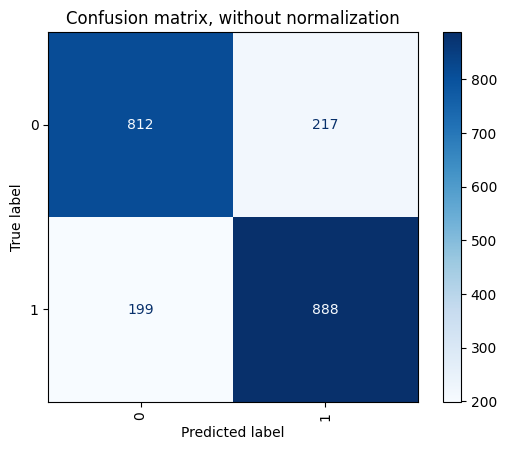

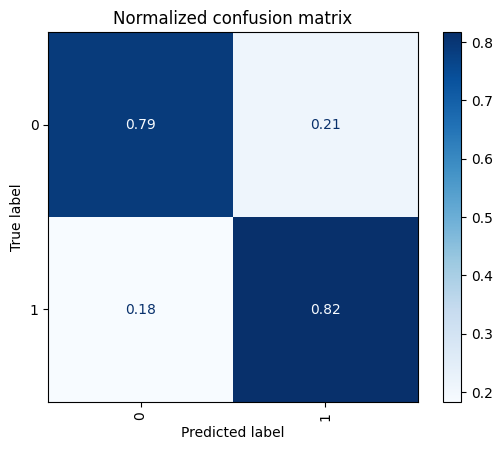

In [50]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
cm = confusion_matrix(y_test, y_pred)
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
    if normalize:
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=classifier.classes_)
        disp = disp.plot(cmap=plt.cm.Blues, values_format='.2f', xticks_rotation='vertical')
    else:
        disp = disp.plot(cmap=plt.cm.Blues, values_format='d', xticks_rotation='vertical')

    disp.ax_.set_title(title)

    print(title)
    print(cm if not normalize else cm_normalized)

plt.show()


In [51]:
y_pred_prob = classifier.predict_proba(X_test)
y_pred_prob[0:5]

array([[0.12674701, 0.87325299],
       [0.17056516, 0.82943484],
       [0.70337483, 0.29662517],
       [0.19957811, 0.80042189],
       [0.15798841, 0.84201159]])

In [52]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_prob[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8624650543618683

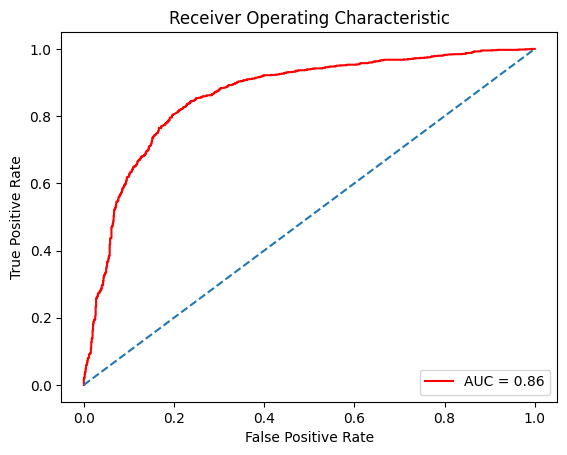

In [53]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.79      0.80      1029
           1       0.80      0.82      0.81      1087

    accuracy                           0.80      2116
   macro avg       0.80      0.80      0.80      2116
weighted avg       0.80      0.80      0.80      2116



In [55]:
dataf_combined = pd.concat([pd.DataFrame(X_test),pd.DataFrame(y_test),pd.DataFrame(y_pred),pd.DataFrame(y_pred_prob)],axis=1)
dataf_combined.columns = ['c_housing','c_loan','c_default','duration','previous','campaign','Target','Target_Pred','Target_Pred_Prob_0','Target_Pred_Prob_1']
dataf_combined.head(10)

,c_housing,c_loan,c_default,duration,previous,campaign,Target,Target_Pred,Target_Pred_Prob_0,Target_Pred_Prob_1
0,-0.949512,-0.393381,-0.117893,-0.332574,0.062612,-0.564943,1,1,0.126747,0.873253
1,-0.949512,-0.393381,-0.117893,0.624597,-0.365356,-0.564943,1,1,0.170565,0.829435
2,-0.949512,-0.393381,-0.117893,-0.656407,-0.365356,-0.191987,0,0,0.703375,0.296625
3,-0.949512,-0.393381,-0.117893,1.541647,-0.365356,-0.564943,1,1,0.199578,0.800422
4,1.053173,-0.393381,-0.117893,0.071501,0.918548,-0.564943,1,1,0.157988,0.842012
5,1.053173,-0.393381,-0.117893,-1.014630,-0.365356,-0.564943,0,0,0.820163,0.179837
6,1.053173,-0.393381,-0.117893,1.607560,0.918548,-0.564943,1,1,0.117133,0.882867
7,-0.949512,-0.393381,-0.117893,-0.905730,-0.365356,-0.191987,0,0,0.925453,0.074547
8,-0.949512,-0.393381,-0.117893,0.590208,-0.365356,-0.191987,0,1,0.189008,0.810992
9,-0.949512,-0.393381,-0.117893,-0.478729,-0.365356,-0.564943,1,1,0.339602,0.660398


In [56]:
df_original_features = pd.DataFrame(X_test, columns=['c_housing','c_loan','c_default','duration','previous','campaign'])
df_original = pd.DataFrame(transformer.inverse_transform(df_original_features), columns=['c_housing','c_loan','c_default','duration','previous','campaign'])

df_original[['Target','Target_Pred','Target_Pred_Prob_0','Target_Pred_Prob_1']] = dataf_combined[['Target','Target_Pred','Target_Pred_Prob_0','Target_Pred_Prob_1']]
df_original.head(10)

,c_housing,c_loan,c_default,duration,previous,campaign,Target,Target_Pred,Target_Pred_Prob_0,Target_Pred_Prob_1
0,0.0,0.0,0.0,263.0,1.0,1.0,1,1,0.126747,0.873253
1,0.0,0.0,0.0,597.0,0.0,1.0,1,1,0.170565,0.829435
2,0.0,0.0,0.0,150.0,0.0,2.0,0,0,0.703375,0.296625
3,0.0,0.0,0.0,917.0,0.0,1.0,1,1,0.199578,0.800422
4,1.0,0.0,0.0,404.0,3.0,1.0,1,1,0.157988,0.842012
5,1.0,0.0,0.0,25.0,0.0,1.0,0,0,0.820163,0.179837
6,1.0,0.0,0.0,940.0,3.0,1.0,1,1,0.117133,0.882867
7,0.0,0.0,0.0,63.0,0.0,2.0,0,0,0.925453,0.074547
8,0.0,0.0,0.0,585.0,0.0,2.0,0,1,0.189008,0.810992
9,0.0,0.0,0.0,212.0,0.0,1.0,1,1,0.339602,0.660398


In [57]:
def asignar_categoria(valor):
    if valor <= 0.2:
        return 'MB'  # Muy bajo
    elif valor <= 0.4:
        return 'B'   # Bajo
    elif valor <= 0.6:
        return 'M'   # Medio
    elif valor <= 0.8:
        return 'A'   # Alto
    else:
        return 'MA'  # Muy alto

df_original['Score'] = df_original['Target_Pred_Prob_1'].apply(asignar_categoria)
df_original

,c_housing,c_loan,c_default,duration,previous,campaign,Target,Target_Pred,Target_Pred_Prob_0,Target_Pred_Prob_1,Score
0,0.0,0.0,0.0,263.0,1.0,1.0,1,1,0.126747,0.873253,MA
1,0.0,0.0,0.0,597.0,0.0,1.0,1,1,0.170565,0.829435,MA
2,0.0,0.0,0.0,150.0,0.0,2.0,0,0,0.703375,0.296625,B
3,0.0,0.0,0.0,917.0,0.0,1.0,1,1,0.199578,0.800422,MA
4,1.0,0.0,0.0,404.0,3.0,1.0,1,1,0.157988,0.842012,MA
...,...,...,...,...,...,...,...,...,...,...,...
2111,1.0,0.0,0.0,144.0,0.0,5.0,0,0,0.862270,0.137730,MB
2112,1.0,0.0,0.0,56.0,0.0,3.0,0,0,0.858295,0.141705,MB
2113,0.0,0.0,0.0,327.0,0.0,1.0,1,1,0.188985,0.811015,MA
2114,1.0,0.0,0.0,821.0,0.0,2.0,1,1,0.143442,0.856558,MA
